<img src="http://www.gavi.org/uploadedimages/about_the_alliance/partners_in_the_alliance/logos/world-bank-logo_700.gif" width="400" height="400" />

Poverty levels are often estimated at the country level by extrapolating the results of surveys taken on a subset of the population at the household or individual level.

The surveys are incredibly informative, but they are also incredibly long. A typical poverty survey has hundreds of questions, ranging from region-specific questions to questions about the last time a participant bought bread. In order to track progress towards its goal, The World Bank needs the most efficient survey possible. 

The present competition, entitled "Pover-T Tests" is about predicting poverty at the household level by building a great classification model. The strongest poverty predictors could be used by statisticians at The World Bank to design new, shorter, equally informative surveys. With these improvements, The World Bank can more easily track progress towards their ambitious and inspiring goal.

# Exploratory analysis

## Import data

In [91]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

### Household-level data

In [2]:
# data directory
if os.path.exists("/Users/manueltonneau/Dropbox/World_Bank_DS_competition/") == True:
    #Manuel
    computer_dir = "/Users/manueltonneau/Dropbox/World_Bank_DS_competition/"
elif os.path.exists("C:\\Users\\elieg\\Dropbox\\World Bank DS competition") == True:
    #Elie
    computer_dir = "C:\\Users\\elieg\\Dropbox\\World Bank DS competition"
elif os.path.exists("C:\\Users\\elieg\\Dropbox\\World Bank DS competition") == True:
    #Elliot
    computer_dir = "C:\\Users\\elieg\\Dropbox\\World Bank DS competition"
DATA_DIR = os.path.join(computer_dir,"data")
data_paths = {'A': {'train': os.path.join(DATA_DIR, 'A', 'A_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'A', 'A_hhold_test.csv')}, 
              
              'B': {'train': os.path.join(DATA_DIR, 'B', 'B_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'B', 'B_hhold_test.csv')}, 
              
              'C': {'train': os.path.join(DATA_DIR, 'C', 'C_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'C', 'C_hhold_test.csv')}}

In [3]:
# load hh-level training data
a_train = pd.read_csv(data_paths['A']['train'], index_col='id')
b_train = pd.read_csv(data_paths['B']['train'], index_col='id')
c_train = pd.read_csv(data_paths['C']['train'], index_col='id')

As usual, let's take a quick look at the head.

In [4]:
a_train.head()

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
id,,,,,,,,,,,,,,,,,,,,,
46107,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,XAmOF,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A
82739,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,lwCkE,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
9646,JhtDR,GUusz,BIZns,ZYabk,uxuSS,PHMVg,NDTCU,sehIp,qNABl,MwLvg,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
10975,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,sPNOc,MwLvg,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
16463,JhtDR,alLXR,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,NdlDR,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,GAZGl,aQeIm,A


The first thing to notice is that each country's surveys have **wildly different numbers of columns**, so we'll plan on training **separate models for each country** and combining our predictions for submission at the end.

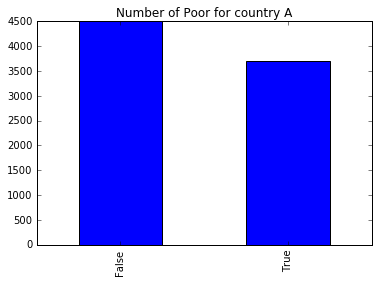

In [5]:
a_train.poor.value_counts().plot.bar(title='Number of Poor for country A')

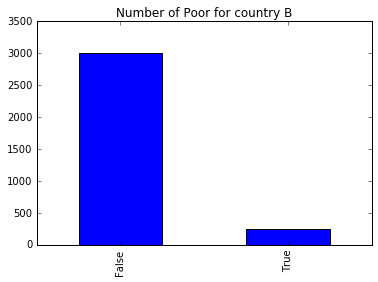

In [6]:
b_train.poor.value_counts().plot.bar(title='Number of Poor for country B')

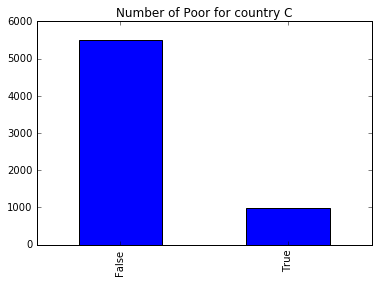

In [7]:
c_train.poor.value_counts().plot.bar(title='Number of Poor for country C')

Country A is well-balanced, but countries B and C are quite unbalanced. This could definitely impact the confidence of our predictor. 

To tackle this problem, there are different possible solutions. To begin with, let's try over-sampling in country B and C.

## Data pre-processing

Country A is well-balanced, but countries B and C are quite unbalanced. This could definitely impact the confidence of our predictor. But solving that problem is up to you – it's outside the scope of this humble benchmark.

In [8]:
# Standardize features
def standardize(df, letter, train_or_test, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    numeric_cols = df[numeric.columns]
    
    # replace NANs by training sample mean values and store them for the test
    if train_or_test == "train":
        meanvalues = pd.DataFrame(numeric_cols.mean()).transpose()
        meanvalues.to_csv(DATA_DIR+"\\"+"meanvalues_hh_"+str(letter))
    meanvalues = pd.read_csv(DATA_DIR+"\\"+"meanvalues_hh_"+str(letter), index_col = "Unnamed: 0")
    for col in numeric_cols.columns:
        numeric_cols[col] = numeric_cols[col].fillna(float(meanvalues[col].values))
    
    # use standard scaling with training sample parameters
    scaler = StandardScaler()
    if train_or_test == "train":
        scaler.fit(numeric_cols)
        joblib.dump(scaler, DATA_DIR+"\\"+"scaler_hh_"+str(letter))
    scaler = joblib.load(DATA_DIR+"\\"+"scaler_hh_"+str(letter))
    numeric_cols = pd.DataFrame(scaler.transform(numeric_cols))
   
    # Former version from competition website: subtracy mean and divide by std
    #df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()

    return df, numeric.columns

def pre_process_data_hh(df, letter, train_or_test, enforce_cols=None):
    print(train_or_test)
    print("Input shape:\t{}".format(df.shape))
        

    df, num_cols = standardize(df, letter, train_or_test)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("----------> After converting categoricals:\t{}".format(df.shape))
    
    # match test set and training set columns
    # here a column is a couple variable-mode
    # if a mode is not present in the test set, a column will be missing -> it needs to be added (and filled with 0)
    if enforce_cols is not None:
        #enforce_cols.remove("id")
        #enforce_cols.remove("iid")
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)
        print("To drop : ", to_drop)
        print("To add : ", to_add)

        df = df.drop(to_drop, axis=1)
        df = df.assign(**{c: 0 for c in to_add})
        print("----------> After adapting columns number:\t{}".format(df.shape))
    
    df.fillna(0, inplace=True)
    
    if train_or_test == "train":
        return df, num_cols
    else:
        return df

In [9]:
print("Country A")
aX_train,num_cols_A = pre_process_data_hh(a_train.drop('poor', axis=1),letter="A",train_or_test = "train")
ay_train = a_train["poor"]

print("\nCountry B")
bX_train,num_cols_B = pre_process_data_hh(b_train.drop('poor', axis=1),letter="B",train_or_test = "train")
by_train = b_train["poor"]

print("\nCountry C")
cX_train,num_cols_C = pre_process_data_hh(c_train.drop('poor', axis=1),letter="C",train_or_test = "train")
cy_train = c_train["poor"]

Country A
train
Input shape:	(8203, 344)


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After standardization (8203, 344)
----------> After converting categoricals:	(8203, 859)

Country B
train
Input shape:	(3255, 441)
After standardization (3255, 441)
----------> After converting categoricals:	(3255, 1432)

Country C
train
Input shape:	(6469, 163)
After standardization (6469, 163)
----------> After converting categoricals:	(6469, 795)


### Import new household-level data

In [10]:
aX_train_1 = pd.read_csv(os.path.join(DATA_DIR,"A","A_hhold_train_new2.csv"))
bX_train_1 = pd.read_csv(os.path.join(DATA_DIR,"B","B_hhold_train_new2.csv"))
cX_train_1 = pd.read_csv(os.path.join(DATA_DIR,"C","C_hhold_train_new2.csv"))

In [11]:
aX_train_1 = aX_train_1.set_index("id")
bX_train_1 = bX_train_1.set_index("id")
cX_train_1 = cX_train_1.set_index("id")

In [12]:
#set up new training data
aX_train_new = pd.merge(aX_train_1,aX_train, left_index=True, right_index=True)
bX_train_new = pd.merge(bX_train_1,bX_train,left_index=True, right_index=True)
cX_train_new = pd.merge(cX_train_1,cX_train, left_index=True, right_index=True)

### Oversampling

In [123]:
sm = SMOTE(kind="regular")
##B
b_x_train_smote_regular,b_y_train_smote_regular = sm.fit_sample(bX_train_new,by_train)
##C
c_x_train_smote_regular,c_y_train_smote_regular = sm.fit_sample(cX_train_new,cy_train)

In [128]:
#back to dataframes
##B
###x
b_x_train_smote_regular = pd.DataFrame(data=b_x_train_smote_regular)
b_x_train_smote_regular.columns = bX_train_new.columns
###y
b_y_train_smote_regular = pd.DataFrame(data=b_y_train_smote_regular)
##C
###x
c_x_train_smote_regular = pd.DataFrame(data=c_x_train_smote_regular)
c_x_train_smote_regular.columns = cX_train_new.columns
###y
c_y_train_smote_regular = pd.DataFrame(data=c_y_train_smote_regular)

The SMOTE method works pretty well :) 

In [ ]:
df.poor.value_counts().plot.bar(title='Number of Poor for country B')

### Test data import

In [13]:
# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

In [14]:
# process the test data
a_test = pre_process_data_hh(a_test, enforce_cols=aX_train.columns.tolist(),letter="A",train_or_test="test")
b_test = pre_process_data_hh(b_test, enforce_cols=bX_train.columns.tolist(),letter="B",train_or_test="test")
c_test = pre_process_data_hh(c_test, enforce_cols=cX_train.columns.tolist(),letter="C",train_or_test="test")

test
Input shape:	(4041, 344)


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After standardization (4041, 344)
----------> After converting categoricals:	(4041, 851)
To drop :  []
To add :  ['LjvKYNON_tFrTi' 'UjuNwfjv_ACFXG' 'UjuNwfjv_ZBMyY' 'UjuNwfjv_ujWYB'
 'nKoaotpH_HQYUq' 'nSzbETYS_yTPHV' 'tHFrzjai_MkATH' 'tHFrzjai_xBZqe']
----------> After adapting columns number:	(4041, 859)
test
Input shape:	(1604, 441)
After standardization (1604, 441)
----------> After converting categoricals:	(1604, 1419)
To drop :  ['RzaXNcgd_YRxyY' 'RzaXNcgd_pqiPu' 'StTakdgB_iszyN' 'TDBNBDil_EeGLR'
 'WTsZXhAX_dWmLT' 'ZehDbxxy_URzxQ' 'dsUYhgai_ioMsc' 'izDpdZxF_SBEBb'
 'qNlGOBmo_YDOTY']
To add :  ['ChbSWYhO_zmaYX' 'DlEhEQvh_fHwsk' 'FlWJlXVX_JSONF' 'HFgaiygl_FWaYd'
 'IrgyDDcl_ZqOTl' 'OrCClDbO_zafmE' 'RVwFIIQe_warmB' 'StTakdgB_OHLNG'
 'UwTBTjzr_QTCdP' 'VMvwrYds_eDLQI' 'ciizMHyv_hylwB' 'cqclFkuK_UMXib'
 'euTESpHe_zVwQw' 'jueNqsUo_iMkzP' 'kmXNWkcV_WklDI' 'knRcLhxE_jUKCa'
 'mMDEItQt_vSoYe' 'pKbELQat_xiPTV' 'qJMRBMxu_uBCoo' 'tkkjBJlG_QUfCR'
 'uHXkmVcG_hZDNP' 'yZSARGEo_zfzTV']
----------> Af

In [15]:
# add new test data from individual-level data analysis
a_test_1 = pd.read_csv(os.path.join(DATA_DIR,"A","A_hhold_test_new2.csv"))
b_test_1 = pd.read_csv(os.path.join(DATA_DIR,"B","B_hhold_test_new2.csv"))
c_test_1 = pd.read_csv(os.path.join(DATA_DIR,"C","C_hhold_test_new2.csv"))

In [16]:
a_test_1 = a_test_1.set_index("id")
b_test_1 = b_test_1.set_index("id")
c_test_1 = c_test_1.set_index("id")

In [17]:
# merge test data
a_test_new = pd.merge(a_test_1, a_test, left_index=True, right_index=True)
b_test_new = pd.merge(b_test_1, b_test, left_index=True, right_index=True)
c_test_new = pd.merge(c_test_1, c_test, left_index=True, right_index=True)

In [62]:
a_test_new.head()

,nb_members_hh,OdXpbPGJ_sum,ukWqmeSS_sum,HeUgMnzF_BNCcM_sum,HeUgMnzF_HUpWg_sum,HeUgMnzF_PAVsH_sum,HeUgMnzF_SJPkb_sum,HeUgMnzF_SlRmt_sum,HeUgMnzF_TRFeI_sum,HeUgMnzF_XJgvq_sum,...,AlDbXTlZ_cecIq,country_A,LjvKYNON_tFrTi,UjuNwfjv_ACFXG,UjuNwfjv_ZBMyY,UjuNwfjv_ujWYB,nKoaotpH_HQYUq,nSzbETYS_yTPHV,tHFrzjai_MkATH,tHFrzjai_xBZqe
id,,,,,,,,,,,,,,,,,,,,,
418,7,20.0,497,0,0,0,0,2,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0
41249,3,8.0,233,0,0,0,0,0,0,0,...,0.0,1.0,0,0,0,0,0,0,0,0
16205,8,24.0,748,0,0,0,0,1,0,0,...,0.0,1.0,0,0,0,0,0,0,0,0
97501,1,4.0,81,0,0,0,0,0,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0
67756,6,16.0,411,0,0,0,0,0,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0


## Scoring: log_loss

### Data cleaning before modelling

In [18]:
#model A
#in case some values are missing, drop the respective columns
for i in aX_train_new.columns.tolist():
    x = aX_train_new[i].isnull().sum()
    if x > 0:
        print(i,x)
        if i.endswith("std"):
            aX_train_new[i].fillna(0,inplace=True)
            a_test_new[i].fillna(0,inplace=True)
            y= aX_train_new[i].isnull().sum()
            print(i,y)
        else:    
            aX_train_new.drop([i],axis=1,inplace=True)
            a_test_new.drop([i],axis=1,inplace=True)

OdXpbPGJ_std 600
OdXpbPGJ_std 0
ukWqmeSS_std 600
ukWqmeSS_std 0


In [19]:
#model B
#in case some values are missing, fill NaNs with 0 if var is std, else drop column
for i in bX_train_new.columns.tolist():
    x = bX_train_new[i].isnull().sum()
    if x > 0:
        print(i,x)
        if i.endswith("std"):
            bX_train_new[i].fillna(0,inplace=True)
            b_test_new[i].fillna(0,inplace=True)
            y= bX_train_new[i].isnull().sum()
            print(i,y)
        else:    
            bX_train_new.drop([i],axis=1,inplace=True)
            b_test_new.drop([i],axis=1,inplace=True)

BoxViLPz_std 77
BoxViLPz_std 0
qlLzyqpP_std 77
qlLzyqpP_std 0
unRAgFtX_std 77
unRAgFtX_std 0
TJGiunYp_std 77
TJGiunYp_std 0
WmKLEUcd_std 77
WmKLEUcd_std 0
DYgxQeEi_std 77
DYgxQeEi_std 0
jfsTwowc_std 77
jfsTwowc_std 0
MGfpfHam_std 77
MGfpfHam_std 0
esHWAAyG_std 77
esHWAAyG_std 0
DtcKwIEv_std 77
DtcKwIEv_std 0
ETgxnJOM_std 77
ETgxnJOM_std 0
gKsBCLMY_std 77
gKsBCLMY_std 0
TZDgOhYY_std 77
TZDgOhYY_std 0
sWElQwuC_std 77
sWElQwuC_std 0
jzBRbsEG_std 77
jzBRbsEG_std 0
CLTXEwmz_std 77
CLTXEwmz_std 0
WqEZQuJP_std 77
WqEZQuJP_std 0
dnmwvCng_std 77
dnmwvCng_std 0
DSttkpSI_std 77
DSttkpSI_std 0
sIiSADFG_std 77
sIiSADFG_std 0
uDmhgsaQ_std 77
uDmhgsaQ_std 0
hdDTwJhQ_std 77
hdDTwJhQ_std 0
AJgudnHB_std 77
AJgudnHB_std 0
iZhWxnWa_std 77
iZhWxnWa_std 0
fyfDnyQk_std 77
fyfDnyQk_std 0
wJthinfa_std 77
wJthinfa_std 0
nxAFXxLQ_std 77
nxAFXxLQ_std 0
mAeaImix_std 77
mAeaImix_std 0
HZqPmvkr_std 77
HZqPmvkr_std 0
ulQCDoYe_std 77
ulQCDoYe_std 0
tzYvQeOb_std 77
tzYvQeOb_std 0
NfpXxGQk_std 77
NfpXxGQk_std 0


In [20]:
#in case some values are missing, fill NaNs with 0 if var is std, else drop column
for i in cX_train_new.columns.tolist():
    x = cX_train_new[i].isnull().sum()
    if x > 0:
        print(i,x)
        if i.endswith("std"):
            cX_train_new[i].fillna(0,inplace=True)
            c_test_new[i].fillna(0,inplace=True)
            y= cX_train_new[i].isnull().sum()
            print(i,y)
        else:    
            cX_train_new.drop([i],axis=1,inplace=True)
            c_test_new.drop([i],axis=1,inplace=True)

XKQWlRjk_std 941
XKQWlRjk_std 0
vWNISgEA_std 941
vWNISgEA_std 0
bsMfXBld_std 941
bsMfXBld_std 0
XKyOwsRR_std 941
XKyOwsRR_std 0
CgAkQtOd_std 941
CgAkQtOd_std 0


### Cross-validation data

In [22]:
aX_train_prelim, aX_test_prelim, ay_train_prelim, ay_test_prelim = train_test_split(aX_train_new, ay_train, test_size=0.1, random_state=0)
bX_train_prelim, bX_test_prelim, by_train_prelim, by_test_prelim = train_test_split(bX_train_new, by_train, test_size=0.1, random_state=0)
cX_train_prelim, cX_test_prelim, cy_train_prelim, cy_test_prelim = train_test_split(cX_train_new, cy_train, test_size=0.1, random_state=0)

In [130]:
#oversampling
## smote regular
bX_train_prelim_smote_regular, bX_test_prelim_smote_regular, by_train_prelim_smote_regular, by_test_prelim_smote_regular = train_test_split(b_x_train_smote_regular, b_y_train_smote_regular, test_size=0.1, random_state=0)
cX_train_prelim_smote_regular, cX_test_prelim_smote_regular, cy_train_prelim_smote_regular, cy_test_prelim_smote_regular = train_test_split(c_x_train_smote_regular, c_y_train_smote_regular, test_size=0.1, random_state=0)

### Modelling for testing

In [142]:
def train_model_rf(features, labels, params, **kwargs):
    # instantiate model
    model = RandomForestClassifier(n_estimators = 400, **params)
    # train model
    model.fit(features, labels)
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print("In-sample accuracy: {accuracy:"+str(accuracy*100)+"%}")
    return model

def train_model_gb(features, labels, kwargs):
    # instantiate model
    model = GradientBoostingClassifier(n_estimators=100,**kwargs)
    # train model
    model.fit(features, labels)
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print("In-sample accuracy: {accuracy:"+str(accuracy*100)+"%}")
    return model

def train_model_xg(features, labels):
    # instantiate model
    model = XGBClassifier(n_estimators= 400)
    # train model
    model.fit(features, labels)
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print("In-sample accuracy: {accuracy:"+str(accuracy*100)+"%}")
    return model

def train_model_nn(features, labels):
    # instantiate model
    model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
    # train model
    model.fit(features, labels)
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print("In-sample accuracy: {accuracy:"+str(accuracy*100)+"%}")
    return model


def train_model_nn_thick(features, labels):
    # instantiate model
    model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
    # train model
    model.fit(features, labels)
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print("In-sample accuracy: {accuracy:"+str(accuracy*100)+"%}")
    return model

In [138]:
a_none = {}

In [155]:
a_smote_regular = {}

#### RF basic and tuned

In [132]:
#model A, no oversampling
param_grid = {'max_depth': np.arange(3, 10), "min_samples_leaf": [1,2,5,10,50,100]}
RF = GridSearchCV(RandomForestClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
RF.fit(aX_train_prelim, ay_train_prelim)
best_params_A = RF.best_params_
model_a_prelim = train_model_rf(aX_train_prelim, ay_train_prelim,best_params_A)

In-sample accuracy: {accuracy:83.13465185586561%}


In [133]:
#model B
param_grid = {'max_depth': np.arange(3, 10), "min_samples_leaf": [1,2,5,10,50,100]}
RF = GridSearchCV(RandomForestClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
RF.fit(bX_train_prelim, by_train_prelim)
best_params_B = RF.best_params_
model_b_prelim = train_model_rf(bX_train_prelim, by_train_prelim,best_params_B)

In-sample accuracy: {accuracy:92.35233868214408%}


In [156]:
#model B, smote regular
param_grid = {'max_depth': np.arange(3, 10), "min_samples_leaf": [1,2,5,10,50,100]}
RF = GridSearchCV(RandomForestClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
RF.fit(bX_train_prelim_smote_regular, by_train_prelim_smote_regular)
best_params_B = RF.best_params_
model_b_prelim_smote_regular = train_model_rf(bX_train_prelim_smote_regular, by_train_prelim_smote_regular,best_params_B)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation

In-sample accuracy: {accuracy:92.52820417976697%}


In [134]:
#model C
param_grid = {'max_depth': np.arange(3, 10), "min_samples_leaf": [1,2,5,10,50,100]}
RF = GridSearchCV(RandomForestClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
RF.fit(cX_train_prelim, cy_train_prelim)
best_params_C = RF.best_params_
model_c_prelim = train_model_rf(cX_train_prelim, cy_train_prelim,best_params_C)

In-sample accuracy: {accuracy:91.27447612504294%}


In [157]:
#model C, smote regular
param_grid = {'max_depth': np.arange(3, 10), "min_samples_leaf": [1,2,5,10,50,100]}
RF = GridSearchCV(RandomForestClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
RF.fit(cX_train_prelim_smote_regular, cy_train_prelim_smote_regular)
best_params_C = RF.best_params_
model_c_prelim_smote_regular = train_model_rf(cX_train_prelim_smote_regular, cy_train_prelim_smote_regular,best_params_C)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation

In-sample accuracy: {accuracy:92.11484027496967%}


#### GB

In [149]:
%%time
#model A
#'max_depth': np.arange(5, 10), "min_samples_leaf": [1,2,5],
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(aX_train_prelim, ay_train_prelim)
best_params_A_gb = GB.best_params_
model_a_prelim_gb = train_model_gb(aX_train_prelim, ay_train_prelim,best_params_A_gb)

In-sample accuracy: {accuracy:94.26984557030616%}
CPU times: user 43.7 s, sys: 1.87 s, total: 45.5 s
Wall time: 48.3 s


In [150]:
#model B, no oversampling
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(bX_train_prelim, by_train_prelim)
best_params_B_gb = GB.best_params_
model_b_prelim_gb = train_model_gb(bX_train_prelim, by_train_prelim,best_params_B_gb)

In-sample accuracy: {accuracy:98.56606350290201%}


In [161]:
#model B, smote regular
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(bX_train_prelim_smote_regular, by_train_prelim_smote_regular)
best_params_B_gb = GB.best_params_
model_b_prelim_gb_smote_regular = train_model_gb(bX_train_prelim_smote_regular, by_train_prelim_smote_regular,best_params_B_gb)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In-sample accuracy: {accuracy:99.61161457370076%}


In [151]:
#model C, no oversampling
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(cX_train_prelim, cy_train_prelim)
best_params_C_gb = GB.best_params_
model_c_prelim_gb = train_model_gb(cX_train_prelim, cy_train_prelim,best_params_C_gb)

In-sample accuracy: {accuracy:100.0%}


In [162]:
#model C, smote regular
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(cX_train_prelim_smote_regular, cy_train_prelim_smote_regular)
best_params_C_gb = GB.best_params_
model_c_prelim_gb_smote_regular = train_model_gb(cX_train_prelim_smote_regular, cy_train_prelim_smote_regular,best_params_C_gb)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In-sample accuracy: {accuracy:100.0%}


#### NN

No oversampling

In [140]:
model_a_prelim_nn = train_model_nn(aX_train_prelim, ay_train_prelim)
model_b_prelim_nn = train_model_nn(bX_train_prelim, by_train_prelim)
model_c_prelim_nn = train_model_nn(cX_train_prelim, cy_train_prelim)

In-sample accuracy: {accuracy:81.94256299105933%}
In-sample accuracy: {accuracy:92.35233868214408%}
In-sample accuracy: {accuracy:91.84129165235314%}


In [146]:
model_a_prelim_nn_thick = train_model_nn_thick(aX_train_prelim, ay_train_prelim)
model_b_prelim_nn_thick = train_model_nn_thick(bX_train_prelim, by_train_prelim)
model_c_prelim_nn_thick = train_model_nn_thick(cX_train_prelim, cy_train_prelim)

In-sample accuracy: {accuracy:81.94256299105933%}
In-sample accuracy: {accuracy:92.35233868214408%}
In-sample accuracy: {accuracy:91.84129165235314%}


Smote regular

In [169]:
model_b_prelim_nn_smote_regular = train_model_nn(bX_train_prelim_smote_regular, by_train_prelim_smote_regular)
model_c_prelim_nn_smote_regular = train_model_nn(cX_train_prelim_smote_regular, cy_train_prelim_smote_regular)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In-sample accuracy: {accuracy:50.064730904383204%}
In-sample accuracy: {accuracy:50.08087343307723%}


In [170]:
model_b_prelim_nn_thick_smote_regular = train_model_nn_thick(bX_train_prelim_smote_regular, by_train_prelim_smote_regular)
model_c_prelim_nn_thick_smote_regular = train_model_nn_thick(cX_train_prelim_smote_regular, cy_train_prelim_smote_regular)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In-sample accuracy: {accuracy:52.32106528574071%}
In-sample accuracy: {accuracy:86.0088960776385%}


### Cross-validation predictions

No oversampling

In [135]:
a_preds_prelim = model_a_prelim.predict_proba(aX_test_prelim)[:, 1]
b_preds_prelim = model_b_prelim.predict_proba(bX_test_prelim)[:, 1]
c_preds_prelim = model_c_prelim.predict_proba(cX_test_prelim)[:, 1]

In [147]:
a_preds_prelim_nn_thick = model_a_prelim_nn_thick.predict_proba(aX_test_prelim)[:, 1]
b_preds_prelim_nn_thick = model_b_prelim_nn_thick.predict_proba(bX_test_prelim)[:, 1]
c_preds_prelim_nn_thick = model_c_prelim_nn_thick.predict_proba(cX_test_prelim)[:, 1]

In [143]:
a_preds_prelim_nn = model_a_prelim_nn.predict_proba(aX_test_prelim)[:, 1]
b_preds_prelim_nn = model_b_prelim_nn.predict_proba(bX_test_prelim)[:, 1]
c_preds_prelim_nn = model_c_prelim_nn.predict_proba(cX_test_prelim)[:, 1]

In [152]:
#gb
a_preds_prelim_gb = model_a_prelim_gb.predict_proba(aX_test_prelim)[:, 1]
b_preds_prelim_gb = model_b_prelim_gb.predict_proba(bX_test_prelim)[:, 1]
c_preds_prelim_gb = model_c_prelim_gb.predict_proba(cX_test_prelim)[:, 1]

Smote regular

In [158]:
#rf
b_preds_prelim_smote_regular = model_b_prelim_smote_regular.predict_proba(bX_test_prelim_smote_regular)[:, 1]
c_preds_prelim_smote_regular = model_c_prelim_smote_regular.predict_proba(cX_test_prelim_smote_regular)[:, 1]

In [165]:
#gb
b_preds_prelim_gb_smote_regular = model_b_prelim_gb_smote_regular.predict_proba(bX_test_prelim_smote_regular)[:, 1]
c_preds_prelim_gb_smote_regular = model_c_prelim_gb_smote_regular.predict_proba(cX_test_prelim_smote_regular)[:, 1]

In [171]:
#nn
b_preds_prelim_nn_smote_regular = model_b_prelim_nn_smote_regular.predict_proba(bX_test_prelim_smote_regular)[:, 1]
c_preds_prelim_nn_smote_regular = model_c_prelim_nn_smote_regular.predict_proba(cX_test_prelim_smote_regular)[:, 1]

In [172]:
#nn
b_preds_prelim_nn_thick_smote_regular = model_b_prelim_nn_thick_smote_regular.predict_proba(bX_test_prelim_smote_regular)[:, 1]
c_preds_prelim_nn_thick_smote_regular = model_c_prelim_nn_thick_smote_regular.predict_proba(cX_test_prelim_smote_regular)[:, 1]

### Scoring: log-loss

No oversampling

In [139]:
a_none["Random Forest tuned model"] = [log_loss(ay_test_prelim,a_preds_prelim),log_loss(by_test_prelim,b_preds_prelim),log_loss(cy_test_prelim,c_preds_prelim)]

{'Random Forest tuned model': [0.4454985029323002,
  0.2541497028931962,
  0.22425909187568546]}

In [144]:
a_none["NN simple model"] = [log_loss(ay_test_prelim,a_preds_prelim_nn),log_loss(by_test_prelim,b_preds_prelim_nn),log_loss(cy_test_prelim,c_preds_prelim_nn)]

In [148]:
a_none["Thicker NN model"] = [log_loss(ay_test_prelim,a_preds_prelim_nn_thick),log_loss(by_test_prelim,b_preds_prelim_nn_thick),log_loss(cy_test_prelim,c_preds_prelim_nn_thick)]

In [153]:
a_none["GB basic model"] = [log_loss(ay_test_prelim,a_preds_prelim_gb),log_loss(by_test_prelim,b_preds_prelim_gb),log_loss(cy_test_prelim,c_preds_prelim_gb)]

Oversampling: smote regular

In [159]:
a_smote_regular["Random Forest tuned model"] = [log_loss(by_test_prelim_smote_regular,b_preds_prelim_smote_regular),log_loss(cy_test_prelim_smote_regular,c_preds_prelim_smote_regular)]

In [166]:
a_smote_regular["GB basic model"] = [log_loss(by_test_prelim_smote_regular,b_preds_prelim_gb_smote_regular),log_loss(cy_test_prelim_smote_regular,c_preds_prelim_gb_smote_regular)]

In [173]:
a_smote_regular["NN simple model"] = [log_loss(by_test_prelim_smote_regular,b_preds_prelim_nn_smote_regular),log_loss(cy_test_prelim_smote_regular,c_preds_prelim_nn_smote_regular)]

In [174]:
a_smote_regular["Thicker NN model"] = [log_loss(by_test_prelim_smote_regular,b_preds_prelim_nn_thick_smote_regular),log_loss(cy_test_prelim_smote_regular,c_preds_prelim_nn_thick_smote_regular)]

### Summary of results

The Gradient boosting seem like a better fit!

In [176]:
df = pd.DataFrame(data=[a_none,a_smote_regular])
df.index = ["No oversampling","Smote regular"]
df.head()

,GB basic model,NN simple model,Random Forest tuned model,Thicker NN model
No oversampling,"[0.28598679202441163, 0.27374637589619777, 0.0...","[0.3906676783786501, 2.8605818216601544, 0.181...","[0.4454985029323002, 0.2541497028931962, 0.224...","[0.3906676783786501, 2.8605818216601544, 0.181..."
Smote regular,"[0.10727653145973436, 0.002144564150809802]","[0.6931630953784355, 0.6931673074941915]","[0.3103718135674576, 0.2676586865580334]","[9.627944009282128, 0.5322087193603185]"


### Final optimization and training

#### Model A

In [59]:
a_test_new.head()

,nb_members_hh,OdXpbPGJ_sum,ukWqmeSS_sum,HeUgMnzF_BNCcM_sum,HeUgMnzF_HUpWg_sum,HeUgMnzF_PAVsH_sum,HeUgMnzF_SJPkb_sum,HeUgMnzF_SlRmt_sum,HeUgMnzF_TRFeI_sum,HeUgMnzF_XJgvq_sum,...,AlDbXTlZ_cecIq,country_A,LjvKYNON_tFrTi,UjuNwfjv_ACFXG,UjuNwfjv_ZBMyY,UjuNwfjv_ujWYB,nKoaotpH_HQYUq,nSzbETYS_yTPHV,tHFrzjai_MkATH,tHFrzjai_xBZqe
id,,,,,,,,,,,,,,,,,,,,,
418,7,20.0,497,0,0,0,0,2,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0
41249,3,8.0,233,0,0,0,0,0,0,0,...,0.0,1.0,0,0,0,0,0,0,0,0
16205,8,24.0,748,0,0,0,0,1,0,0,...,0.0,1.0,0,0,0,0,0,0,0,0
97501,1,4.0,81,0,0,0,0,0,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0
67756,6,16.0,411,0,0,0,0,0,0,0,...,1.0,1.0,0,0,0,0,0,0,0,0


In [186]:
%%time
#model A
#'max_depth': np.arange(5, 10), "min_samples_leaf": [1,2,5],
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(aX_train_new, ay_train)
best_params_A_gb = GB.best_params_
model_a_gb = train_model_gb(aX_train_new, ay_train, best_params_A_gb)

In-sample accuracy: {accuracy:93.6364744605632%}
CPU times: user 46.5 s, sys: 2.11 s, total: 48.6 s
Wall time: 51 s


#### Model B, smote regular oversampling

Let's look at the differences between bX_train_new and b_test_new

In [188]:
%%time
#model b
#'max_depth': np.arange(5, 10), "min_samples_leaf": [1,2,5],
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(b_x_train_smote_regular, b_y_train_smote_regular)
best_params_B_gb = GB.best_params_
model_b_gb = train_model_gb(b_x_train_smote_regular, b_y_train_smote_regular, best_params_B_gb)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In-sample accuracy: {accuracy:99.56724367509987%}
CPU times: user 3min 12s, sys: 4.88 s, total: 3min 17s
Wall time: 3min 28s


#### Model C

In [190]:
%%time
#model C
#'max_depth': np.arange(5, 10), "min_samples_leaf": [1,2,5],
param_grid = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
GB = GridSearchCV(GradientBoostingClassifier(n_estimators=1), param_grid,scoring="neg_log_loss")
GB.fit(c_x_train_smote_regular, c_y_train_smote_regular)
best_params_C_gb = GB.best_params_
model_c_gb = train_model_gb(c_x_train_smote_regular, c_y_train_smote_regular, best_params_C_gb)

/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/manueltonneau/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In-sample accuracy: {accuracy:100.0%}
CPU times: user 2min 1s, sys: 2.88 s, total: 2min 4s
Wall time: 2min 13s


## Prediction

In [191]:
a_preds = model_a_gb.predict_proba(a_test_new)
b_preds = model_b_gb.predict_proba(b_test_new)
c_preds = model_c_gb.predict_proba(c_test_new)

## Save submission

In [192]:
def make_country_sub(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds[:, 1],  # proba p=1
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]

In [193]:
# convert preds to data frames
a_sub = make_country_sub(a_preds, a_test_new, 'A')
b_sub = make_country_sub(b_preds, b_test_new, 'B')
c_sub = make_country_sub(c_preds, c_test_new, 'C')

It's time to combine our predictions and save for submission!

In [194]:
submission = pd.concat([a_sub, b_sub, c_sub])

How about one last look at the fruits of or hard work...

In [197]:
submission.head(n=1000)

,country,poor
id,,
418,A,1.210194e-04
41249,A,2.250886e-05
16205,A,8.126932e-05
97501,A,2.049234e-04
67756,A,8.274764e-04
17938,A,5.415985e-05
19036,A,1.720262e-06
61587,A,1.177086e-03
57571,A,1.014458e-04


In [198]:
submission.to_csv('/Users/manueltonneau/Dropbox/World_Bank_DS_competition/submission/gb_tuned_smote_regular1.csv')